# 顔文字生成器（サンプル）
VAE(Variational Auto Encoder)を用いた構成

In [2]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.autograd as autograd

## 前処理

### データ読み込み

In [3]:
# 特殊文字
sp = {'pad': '<PAD>',
      # 'bos': '<BOS>',
      # 'eos': '<EOS>',
      'unk': '<UNK>'}
# pad : padding. 文字列長を一定にするために使う
# bos : begin of sequence. 文頭文字．Decoderの最初の入力
# eos : end of sequence. 文末文字．
# unk : unknown. 出現数が低いものに割り当てる

In [4]:
sp.values()

dict_values(['<PAD>', '<UNK>'])

In [5]:
KAOMOJI_MAX = 10    # 顔文字最大長

kmj_list = []       # 顔文字リスト
len_list = []       # <BOS> から <EOS> までの文字数のリスト
char_list = []      # 顔文字に使用されている文字のリスト

char_list += list(sp.values())
file_name = 'kaomoji_MAX=' + str(KAOMOJI_MAX) + '.txt'

with open(file_name, mode='r') as file:
  for line in file:
    # temp = [sp['bos']]
    temp = list(line.replace('\n', ''))
    # temp += [sp['eos']]
    len_list.append(len(temp))
    temp += [sp['pad'] for _ in range(KAOMOJI_MAX - len(temp))]
    kmj_list.append(temp)
    char_list += temp

# 重複を消す
char_list = sorted(set(char_list), key=char_list.index)

In [6]:
print(kmj_list[0])

['(', '(', '(', '\u3000', '̄', 'ー', '\u3000', '̄', '\u3000', ')']


In [7]:
print('Number of kaomoji  :', len(kmj_list))
print('Number of character:', len(char_list))

Number of kaomoji  : 5457
Number of character: 719


### 出現数が少ないものを置換

In [8]:
# 最小出現数
MIN_APPEAR = 20

kmj_list = np.array(kmj_list)

cnt = 0
for c in char_list:
  mask = (kmj_list == c)
  if np.sum(mask) < MIN_APPEAR:
    kmj_list[mask] = sp['unk']

char_list = list(sp.values()) + kmj_list.flatten().tolist()
char_list = sorted(set(char_list), key=char_list.index)

In [9]:
print('Number of character:', len(char_list))

Number of character: 137


### 添字検索
顔文字に使われる文字が文字リストの何番目にあるか調べる

In [10]:
kmj_index = []    # 添字リスト

for kmj in kmj_list.tolist():
  temp = [char_list.index(c) for c in kmj]
  kmj_index.append(temp)

In [11]:
print(len_list[0])
kmj_index[0]

10


[2, 2, 2, 3, 4, 5, 3, 4, 3, 6]

### One-hotベクトル化



In [12]:
kmj_num = len(kmj_index)        # 顔文字の総数
kmj_size = len(kmj_index[0])    # 1つの顔文字の長さ
char_num = len(char_list)       # 文字の種類数

# One-hotベクトルリスト
kmj_onehot = np.zeros((kmj_num, kmj_size, char_num))

for i, index in enumerate(kmj_index):
  mask = range(char_num) == np.array(index).reshape((kmj_size, 1))
  kmj_onehot[i][mask] = 1

In [13]:
kmj_onehot.shape

(5457, 10, 137)

### 訓練・検証・テスト用に分ける

In [14]:
dataset = torch.utils.data.TensorDataset(
  torch.tensor(kmj_onehot.astype('float32')),
  torch.tensor(len_list)
)

In [15]:
train_size = int(len(dataset) * 0.85)
valid_size = int(len(dataset) * 0.10)
test_size  = len(dataset) - train_size - valid_size

# indices = np.arange(len(dataset))

# dataset_train = torch.utils.data.Subset(dataset, indices[:train_size])
# dataset_valid = torch.utils.data.Subset(dataset, indices[train_size:train_size+valid_size])
# dataset_test  = torch.utils.data.Subset(dataset, indices[train_size+valid_size:])

split = [train_size, valid_size, test_size]

dataset_train, dataset_valid, dataset_test = torch.utils.data.random_split(dataset, split)

In [16]:
dataset_train[0]

(tensor([[0., 0., 1.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]),
 tensor(10))

In [17]:
batch_size = 32

dataloader_train = torch.utils.data.DataLoader(
  dataset_train,
  batch_size=batch_size,
  shuffle=True
)

dataloader_valid = torch.utils.data.DataLoader(
  dataset_valid,
  batch_size=batch_size,
  shuffle=True
)

In [18]:
for x, len_seq in dataloader_train:
  print(x.shape, len_seq.shape)
  break

torch.Size([32, 10, 137]) torch.Size([32])


## モデル

### Encoder

In [19]:
class Encoder(nn.Module):
  def __init__(self, N, in_dim, emb_dim, hid_dim, z_dim):
    super().__init__()
    self.emb = nn.Linear(in_dim, emb_dim, bias=False)
    self.pos_emb = torch.nn.Parameter(torch.randn(1, N, emb_dim))
    self.flat = nn.Flatten()
    self.linear1 = nn.Linear(N*emb_dim, hid_dim)
    self.linear2 = nn.Linear(hid_dim, hid_dim)
    self.linear_mean = nn.Linear(hid_dim, z_dim)
    self.linear_var = nn.Linear(hid_dim, z_dim)

  def forward(self, x):
    x = self.emb(x) + self.pos_emb
    x = self.flat(x)
    x = self.linear1(x)
    x = self.linear2(x)
    mean = self.linear_mean(x)
    std = self.linear_var(x)
    return mean, std

In [20]:
encoder = Encoder(20, 269, 16, 64, 2)
x = torch.rand(32, 20, 269)
encoder(x)[0].shape

torch.Size([32, 2])

### Decoder

In [21]:
class Decoder(nn.Module):
  def __init__(self, in_dim, hid_dim, out_dim):
    super().__init__()
    self.linear1 = nn.Linear(in_dim, hid_dim)
    self.linear2 = nn.Linear(hid_dim, hid_dim)
    self.linear3 = nn.Linear(hid_dim, out_dim)

  def forward(self, x):
    x = self.linear1(x)
    x = self.linear2(x)
    return torch.sigmoid(self.linear3(x))

In [22]:
decoder = Decoder(2, 64, 20*269)
x = torch.rand(32, 2)
decoder(x).shape

torch.Size([32, 5380])

### Generator

In [23]:
def torch_log(x):
    """torch.log(0)によるnanを防ぐ．
    """
    return torch.log(torch.clamp(x, min=1e-10))

In [24]:
class Generator(nn.Module):
  def __init__(self, N, in_dim, emb_dim, hid_dim, z_dim):
    super().__init__()
    self.N = N
    self.in_dim = in_dim
    self.encoder = Encoder(N, in_dim, emb_dim, hid_dim, z_dim)
    self.decoder = Decoder(z_dim, hid_dim, N*in_dim)

  def forward(self, x):
    mean, std = self.encoder(x)
    z = mean + std * torch.randn(mean.shape)
    y = self.decoder(z)
    return y.view(-1, self.N, self.in_dim)

  def loss(self, x):
      mean, std = self.encoder(x)

      # KL loss(正則化項)の計算.
      KL = -0.5 * torch.mean(torch.sum(1 + torch_log(std**2) - mean**2 - std**2, dim=1))

      z = mean + std * torch.randn(mean.shape)
      y = self.decoder(z)

      # reconstruction loss(負の再構成誤差)の計算.
      x = x.flatten(start_dim=1)
      reconstruction = torch.mean(torch.sum(x * torch_log(y) + (1 - x) * torch_log(1 - y), dim=1))

      return KL, -reconstruction

In [25]:
generator = Generator(20, 269, 16, 64, 2)
x = torch.rand(32, 20, 269)
generator(x).shape

torch.Size([32, 20, 269])

## 学習

In [26]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [59]:
n_epochs = 20

N = KAOMOJI_MAX
in_dim = len(char_list)
emb_dim = 16
hid_dim = 64
z_dim = 2

net = Generator(N, in_dim, emb_dim, hid_dim, z_dim)

optimizer = optim.Adam(net.parameters())

In [60]:
for epoch in range(n_epochs):
  losses = []
  KL_losses = []
  reconstruction_losses = []

  net.train()
  for x, _ in dataloader_train:
    x = x.to(device)

    net.zero_grad()

    # KL_loss, reconstruction_lossの各項の計算
    KL_loss, reconstruction_loss = net.loss(x)
    loss = KL_loss + reconstruction_loss

    loss.backward()
    optimizer.step()

    losses.append(loss.cpu().detach().numpy())
    KL_losses.append(KL_loss.cpu().detach().numpy())
    reconstruction_losses.append(reconstruction_loss.cpu().detach().numpy())

  losses_val = []
  net.eval()
  for x, _ in dataloader_valid:
    x = x.to(device)

    KL_loss, reconstruction_loss = net.loss(x)
    loss = KL_loss + reconstruction_loss

    losses_val.append(loss.cpu().detach().numpy())

  if (epoch+1) % 5 == 0:
    print('EPOCH: {:>2}   Train Lower Bound: {:>2.3f} (KL_loss: {:>2.3f}. reconstruction_loss:{:>2.3f})   Valid Lower Bound: {:>2.3f}'.format(
        epoch+1,
        np.mean(losses),
        np.mean(KL_losses),
        np.mean(reconstruction_losses),
        np.mean(losses_val)
    ))

EPOCH:  5   Train Lower Bound: 39.260 (KL_loss: 1.454. reconstruction_loss:37.806)   Valid Lower Bound: 38.531
EPOCH: 10   Train Lower Bound: 36.240 (KL_loss: 1.114. reconstruction_loss:35.125)   Valid Lower Bound: 35.359
EPOCH: 15   Train Lower Bound: 35.356 (KL_loss: 1.198. reconstruction_loss:34.158)   Valid Lower Bound: 35.937
EPOCH: 20   Train Lower Bound: 35.208 (KL_loss: 1.410. reconstruction_loss:33.798)   Valid Lower Bound: 34.331


## 評価

In [61]:
def convert_str(x):
  x = np.array(char_list)[x.argmax(dim=1)]
  x = [c for c in x if c not in sp.values()]

  return ''.join(x)

def generate(net, base=None, rate=3.0):
  if base is None:
    z = rate * torch.randn(1, z_dim)
  else:
    z, _ = net.encoder(base.unsqueeze(0))
    eps = 2*rate * torch.rand(1, z_dim) - rate
    z = z + eps

  y = net.decoder(z)
  gen = convert_str(y.view(KAOMOJI_MAX, len(char_list)))

  return ''.join(gen)

### 次元圧縮テスト
目標はbaseとgenerateで全く同じもの．
次元圧縮して，潜在ベクトルが獲得できているかどうかのテスト．

In [62]:
for i in np.random.randint(0, len(dataset_test), size=10):
  test = dataset_test[i][0]
  print('base     :', convert_str(test))
  print('generate :', generate(net, base=test, rate=0.0))

base     : (゚ω゚;A)
generate : ((　))
base     : (^^ゞ
generate : (^_)
base     : m(。≧д≦。)m
generate : ((　̄　))))
base     : (　́・ω・`)ノ♪
generate : ((　　　　)))
base     : (*☆≦*)
generate : ((　)))
base     : (ノ_·,)
generate : (())
base     : _ロ(・ω・=)
generate : ((　　　)))
base     : (;　́-ω-`)ヾ
generate : ((　　　　)))
base     : (ω)
generate : ((　)))
base     : ('o').。
generate : (　_))


### 生成テスト
潜在ベクトルに乱数を入力しその出力を見る．

In [63]:
for _ in range(10):
  print('generate :', generate(net, base=None, rate=5.0))

generate : (≧∀☆)
generate : (　((　　))))
generate : ♪(　((ω̄̄))
generate : ·!ヽ(′∇ω̄))
generate : ((　(　　̄)))
generate : (　　　))))
generate : (꒪_;)
generate : ·!ヽ(′∇ω̄))
generate : ♪(　̄(ωω̄)ノ
generate : ∀!๑̄(ωω　　


### 類似度テスト
訓練データの中から潜在ベクトルの距離が近いものを見る．

In [64]:
def similar(net, base, num=10):
  z, _ = net.encoder(base.unsqueeze(0))

  size = list(z.shape)
  size[0] = 0
  z_list = torch.empty(size, dtype=torch.float)
  z_list, _ = net.encoder(dataset_train[:][0])

  diff = z_list - z
  norm = enumerate(torch.norm(diff, dim=1))
  norm = sorted(norm, key=lambda x: x[1])

  for i in range(num):
    min_index = norm[i][0]
    str = convert_str(dataset_train[min_index][0])
    print('{} : {}'.format(str, norm[i][1]))

In [65]:
i = np.random.randint(0, len(dataset_test))
test = dataset_test[i][0]
print(convert_str(test), ' : base')
similar(net, test, num=10)

_ヽ(・・〃)m  : base
(　゚∀　゚*) : 0.0153358718380332
(*　́ω`)σ : 0.02588500641286373
(　゚へ　゚;) : 0.029450103640556335
(　́д`)/ : 0.030462097376585007
<　́ω`　>q : 0.03201581537723541
(　́;ω;`) : 0.032138723880052567
(‘・O・‘:) : 0.03802742809057236
(●’v`*) : 0.042245373129844666
(`·ω·　́) : 0.042882490903139114
(　́・-・。) : 0.04563275724649429


### 潜在ベクトルの分布図

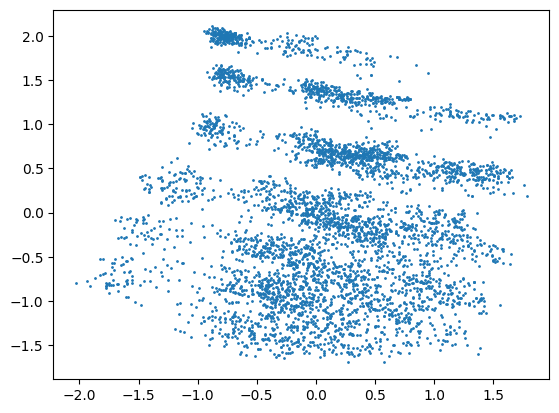

In [66]:
assert z_dim == 2

z_list, _ = net.encoder(dataset_train[:][0])
z_list = z_list.detach().numpy()
x = z_list[:, 0]
y = z_list[:, 1]

plt.scatter(x, y, s=1)
plt.show()

## 感想

このネットワークは，  
Encoder：Embedding+Flatten+Linear×3  
Decoder：Linear×3  
の構成

Encoderで平均値と標準偏差を計算し，それを元に正規分布でサンプリングする．
サンプリングした値をDecoderに入力する．  
だから，正規分布の乱数で生成した値をDecoderに入力してもそれっぽいものが出る．

これは，色々参考にしながら適当に作ったから合っているか不明．  
顔文字分類とかもできそう？

性能は全然ダメだが，一番生成器っぽい．

